# ふるさと納税クロスABC分析

ここでは，クロスABC分析の例として自治体別のふるさと納税のデータを用いて簡単な分類をおこないます．寄付金額と寄付件数を指標として，寄付金額，寄付件数がともに多い自治体を洗い出したり，寄付金額は多いけれども寄付件数が少ない自治体，あるいはその逆の自治体を抽出してみたいと思います．

## 下準備

分析をおこなうにあたって必要となるライブラリのインポートをおこないます．今回は数値計算をおこなう**numpy**，描画処理をおこなう **matplotlib** と **seaborn**，さらにデータの処理などを楽におこなうことができる **pandas**を用います．

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## データ紹介

それでは今回扱うデータ **example.csv** を紹介します．
今回のデータは **ふるさと納税** に関するデータであり，**2008年度** から **2019年度** における各自治体の **寄付金額(amount_)**(単位は千円) と **寄付件数(number_)**(単位は件) が入力されています．
**出典** は **総務省のふるさと納税ポータルサイト** の[関連資料](https://www.soumu.go.jp/main_sosiki/jichi_zeisei/czaisei/czaisei_seido/furusato/archive/)であり，そちらを元に加工しました．
さっそくみてみましょう．

In [2]:
df = pd.read_csv('example.csv', index_col=1)

df.head()

,Prefecture,amount_2008,amount_2009,amount_2010,amount_2011,amount_2012,amount_2013,amount_2014,amount_2015,amount_2016,...,number_2010,number_2011,number_2012,number_2013,number_2014,number_2015,number_2016,number_2017,number_2018,number_2019
City,,,,,,,,,,,,,,,,,,,,,
北海道,北海道,4660,52685,2770,3670,5688,10792,1798,2144,13457,...,25.0,32.0,139.0,267.0,64.0,39.0,51,98,3996,324
札幌市,北海道,397801,514419,11073,100330,121572,139244,200533,106100,364428,...,88.0,247.0,365.0,177.0,170.0,200.0,300,247,1219,2240
函館市,北海道,5177,4745,3301,3846,5139,14880,10573,17032,11380,...,47.0,53.0,66.0,150.0,257.0,240.0,207,4211,10744,43753
小樽市,北海道,56757,22717,30036,23209,11971,27136,38989,33039,50892,...,185.0,163.0,165.0,204.0,239.0,193.0,781,5552,7644,7346
旭川市,北海道,14090,33603,10271,7161,8414,22468,41834,103494,182256,...,98.0,84.0,95.0,150.0,224.0,2806.0,5404,7269,26142,81238


**City** 列には，**各自治体の名前** が入力されています．またCity列に **県の名前** が入力されている場合は，ふるさと納税がその **県** に対して納められたということになります．

## クロスABC分析の実行

それではこのようなデータに対してクロスABC分析をおこなってみましょう．まずは**2019年度** において，**寄付金額(amount_2019)** と **寄付件数(number_2019)** が両者ともに多かった自治体を抽出します．そのために分析用にデータを整形し直します．また，クロスABC分析がどのような分析手法なのか手短に知りたい方は，こちらの[記事](https://biz.moneyforward.com/accounting/basic/22225/)を一読ください．

## 初期化処理

In [3]:
INDICATOR_1 = "amount_2019"
INDICATOR_2 = "number_2019"
indicators = [INDICATOR_1, INDICATOR_2]

In [4]:
analyzed_df = df[["Prefecture"] + indicators]

analyzed_df

,Prefecture,amount_2019,number_2019
City,,,
北海道,北海道,8209,324
札幌市,北海道,456499,2240
函館市,北海道,579859,43753
小樽市,北海道,152107,7346
旭川市,北海道,1313437,81238
...,...,...,...
久米島町,沖縄県,166852,6708
八重瀬町,沖縄県,307445,17592
多良間村,沖縄県,13392,149


## ランク付け

### 各項目ごとにステップ1からスタップ3の操作をおこなう

#### 値が大きい順にソート

寄付金額の項目(```INDICATOR_1```)からおこないます．ステップ1では，寄付金額の値が大きい順に並べ替えをおこないます．例えば，2019年において寄付金額が多い順に自治体を並べ直すと，

In [5]:
analyzed_df = analyzed_df.sort_values(INDICATOR_1, ascending=False)  # INDICATOR_1 = "amount_2019"

analyzed_df

,Prefecture,amount_2019,number_2019
City,,,
泉佐野市,大阪府,18496917,307630
都城市,宮崎県,10645341,503916
紋別市,北海道,7737695,448803
白糠町,北海道,6733389,460533
根室市,北海道,6589107,413575
...,...,...,...
大桑村,長野県,65,4
滑川町,埼玉県,22,3
青ヶ島村,東京都,18,8


となります．

#### 自治体$i$までの累積和が全体の何割になっているか求める

In [6]:
cum_ratio_series = analyzed_df[INDICATOR_1].cumsum() / analyzed_df[INDICATOR_1].sum()
cum_ratio_series = cum_ratio_series.rename(f"cum_ratio_{INDICATOR_1}")

cum_ratio_series

City
泉佐野市    0.037939
都城市     0.059774
紋別市     0.075645
白糠町     0.089456
根室市     0.102971
          ...   
大桑村     1.000000
滑川町     1.000000
青ヶ島村    1.000000
飛島村     1.000000
御蔵島村    1.000000
Name: cum_ratio_amount_2019, Length: 1788, dtype: float64

これはすなわち，泉佐野市の寄付金額のみで自治体全部の寄付金額の4%近くを占めており，泉佐野市と都城市の寄付金額の合計が自治体全部の寄付金額の6%近くを，泉佐野市と都城市と紋別市の寄付金額の合計が自治体全部の寄付金額の7.5%近くを...といったことを表しています．

#### ランクの付与

累積和が全体に占める割合を用いて各自治体にランクを付与します．ここではcum_ratioの値が0.1以下であれば最高のランクである1を，0.1より大きく0.2より小さい場合は次点のランク2を...といったように10個のランクで各自治体を評価します(cum_ratioの値が小さいほうがより寄付金額が多いことに注意してください)．

In [7]:
tier_series = np.ceil(cum_ratio_series * 10).astype(int)
tier_series = tier_series.rename(f"tier_{INDICATOR_1}")

tier_series

City
泉佐野市     1
都城市      1
紋別市      1
白糠町      1
根室市      2
        ..
大桑村     10
滑川町     10
青ヶ島村    10
飛島村     10
御蔵島村    10
Name: tier_amount_2019, Length: 1788, dtype: int64

In [8]:
analyzed_df = pd.concat([analyzed_df, tier_series], axis=1)

analyzed_df

,Prefecture,amount_2019,number_2019,tier_amount_2019
City,,,,
泉佐野市,大阪府,18496917,307630,1
都城市,宮崎県,10645341,503916,1
紋別市,北海道,7737695,448803,1
白糠町,北海道,6733389,460533,1
根室市,北海道,6589107,413575,2
...,...,...,...,...
大桑村,長野県,65,4,10
滑川町,埼玉県,22,3,10
青ヶ島村,東京都,18,8,10


ここまでの処理で**寄付金額**について各自治体のランク付けは完了です．**寄付件数**についても同様にランク付けをおこなうことができます．

#### 値が大きい順にソート

In [9]:
analyzed_df = analyzed_df.sort_values(INDICATOR_2, ascending=False)  # INDICATOR_2 = "number_2019"

analyzed_df

,Prefecture,amount_2019,number_2019,tier_amount_2019
City,,,,
都城市,宮崎県,10645341,503916,1
白糠町,北海道,6733389,460533,1
紋別市,北海道,7737695,448803,1
根室市,北海道,6589107,413575,2
泉佐野市,大阪府,18496917,307630,1
...,...,...,...,...
新島村,東京都,10310,3,10
刈羽村,新潟県,70,2,10
瑞穂町,東京都,100,1,10


#### 自治体$i$までの累積和が全体の何割になっているか求める

In [10]:
cum_ratio_series = analyzed_df[INDICATOR_2].cumsum() / analyzed_df[INDICATOR_2].sum()
cum_ratio_series = cum_ratio_series.rename(f"cum_ratio_{INDICATOR_2}")

cum_ratio_series

City
都城市     0.021594
白糠町     0.041329
紋別市     0.060561
根室市     0.078283
泉佐野市    0.091466
          ...   
新島村     1.000000
刈羽村     1.000000
瑞穂町     1.000000
飛島村     1.000000
御蔵島村    1.000000
Name: cum_ratio_number_2019, Length: 1788, dtype: float64

#### ランクの付与

In [11]:
tier_series = np.ceil(cum_ratio_series * 10).astype(int)
tier_series = tier_series.rename(f"tier_{INDICATOR_2}")

tier_series

City
都城市      1
白糠町      1
紋別市      1
根室市      1
泉佐野市     1
        ..
新島村     10
刈羽村     10
瑞穂町     10
飛島村     10
御蔵島村    10
Name: tier_number_2019, Length: 1788, dtype: int64

In [12]:
analyzed_df = pd.concat([analyzed_df, tier_series], axis=1)

analyzed_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
都城市,宮崎県,10645341,503916,1,1
白糠町,北海道,6733389,460533,1,1
紋別市,北海道,7737695,448803,1,1
根室市,北海道,6589107,413575,2,1
泉佐野市,大阪府,18496917,307630,1,1
...,...,...,...,...,...
新島村,東京都,10310,3,10,10
刈羽村,新潟県,70,2,10,10
瑞穂町,東京都,100,1,10,10


### まとめ

ここまで各自治体について寄付金額と寄付件数の側面からランク付けをおこないました．ランク付け処理はfor文を用いると以下のように書くことができます．なお，いまランクの数は10個としているので，各項目でランク1に属する自治体はその項目で上位10%の自治体，ランク2は上位20%の自治体，のようにいうことができます．ランク数を20個とした場合，ランク1は上位5%，ランク2は上位10%のように変化します．

In [13]:
INDICATOR_1 = "amount_2019"
INDICATOR_2 = "number_2019"
indicators = [INDICATOR_1, INDICATOR_2]

In [14]:
NUM_TIERS = 10
analyzed_df = df[["Prefecture"] + indicators]

for i in indicators:
    analyzed_df = analyzed_df.sort_values(i, ascending=False)
    cum_ratio_series = analyzed_df[i].cumsum() / analyzed_df[i].sum()
    tier_series = np.ceil(cum_ratio_series * NUM_TIERS).astype(int)
    tier_series = tier_series.rename(f"tier_{i}")
    analyzed_df = pd.concat([analyzed_df, tier_series], axis=1)

analyzed_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
都城市,宮崎県,10645341,503916,1,1
白糠町,北海道,6733389,460533,1,1
紋別市,北海道,7737695,448803,1,1
根室市,北海道,6589107,413575,2,1
泉佐野市,大阪府,18496917,307630,1,1
...,...,...,...,...,...
新島村,東京都,10310,3,10,10
刈羽村,新潟県,70,2,10,10
瑞穂町,東京都,100,1,10,10


## 分析

それでは，各項目の各ランクにどのくらいの自治体が属しているのか見てみましょう．各項目の各ランクに属する自治体数は，groupbyを用いて集計します．

In [15]:
num_belong_tier_each_indicators = analyzed_df.groupby([f'tier_{i}' for i in indicators]).size()

num_belong_tier_each_indicators.head()

tier_amount_2019  tier_number_2019
1                 1                   4
2                 1                   1
                  2                   6
                  3                   3
                  4                   1
dtype: int64

そのまま利用することは難しいので，```histgram```というリストへ格納します．

In [16]:
NUM_TIERS = 10
histgram = [[0 for _ in range(1, NUM_TIERS + 1)] for _ in range(1, NUM_TIERS + 1)]
for key, value in num_belong_tier_each_indicators.to_dict().items():
    tier_indicator_1, tier_indicator_2 = key
    histgram[tier_indicator_1 - 1][tier_indicator_2 - 1] = value

histgram

[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 6, 3, 1, 0, 1, 0, 0, 0, 0],
 [0, 5, 9, 1, 2, 0, 1, 2, 0, 0],
 [0, 0, 4, 13, 8, 4, 1, 0, 0, 0],
 [0, 0, 2, 9, 13, 8, 3, 5, 2, 2],
 [0, 0, 0, 2, 14, 19, 17, 7, 4, 3],
 [0, 0, 0, 1, 2, 20, 30, 20, 9, 9],
 [0, 0, 0, 0, 0, 3, 25, 51, 40, 15],
 [0, 0, 0, 0, 0, 0, 4, 35, 116, 74],
 [0, 0, 0, 0, 0, 0, 0, 1, 46, 1111]]

さらに扱いやすくするため，```histgram_df```というpandas.DataFrameオブジェクトへと格納します．

In [17]:
# pd.DataFrameへと変換
axis_name = [f'tier_{i}' for i in range(1, NUM_TIERS + 1)]
histgram_df = pd.DataFrame(histgram, index=axis_name, columns=axis_name)

# 最初に指定したindicator(ここでは寄付金額)が横軸にくるようにする
histgram_df = histgram_df.T

histgram_df

,tier_1,tier_2,tier_3,tier_4,tier_5,tier_6,tier_7,tier_8,tier_9,tier_10
tier_1,4,1,0,0,0,0,0,0,0,0
tier_2,0,6,5,0,0,0,0,0,0,0
tier_3,0,3,9,4,2,0,0,0,0,0
tier_4,0,1,1,13,9,2,1,0,0,0
tier_5,0,0,2,8,13,14,2,0,0,0
tier_6,0,1,0,4,8,19,20,3,0,0
tier_7,0,0,1,1,3,17,30,25,4,0
tier_8,0,0,2,0,5,7,20,51,35,1
tier_9,0,0,0,0,2,4,9,40,116,46
tier_10,0,0,0,0,2,3,9,15,74,1111


よって，寄付金額も寄付件数もランク1に属している自治体は4つ，などといった情報がわかりました．とはいえこの```histgram_df```は見づらいのでもう少し見やすくしてみます．

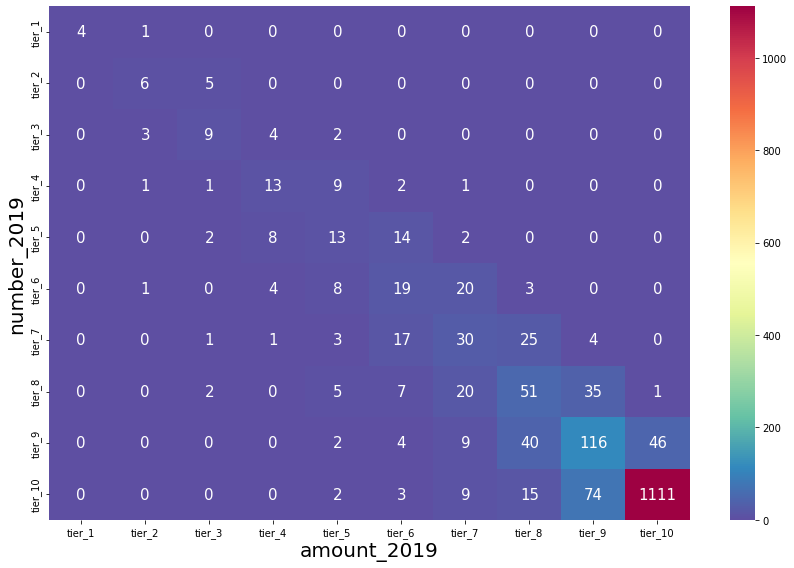

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(histgram_df, annot=True, annot_kws={'fontsize': 15}, fmt='d', cmap='Spectral_r')
plt.xlabel('amount_2019', fontsize=20)
plt.ylabel('number_2019', fontsize=20)
plt.tight_layout()

綺麗に描画できました．ここで，左上のマスのように，寄付金額も寄付件数も最も多いグループには果たしてどのような自治体が含まれているのでしょうか．またそのような自治体に共通するような特徴はあるのでしょうか．さっそく検証してみましょう．寄付件数，寄付金額ともにランク1に属する自治体(10個のランクで評価している場合には上位10%の自治体)を取り出します．

In [19]:
tier = 1
star_df = analyzed_df[analyzed_df[f'tier_{INDICATOR_1}'] <= tier]
star_df = star_df[star_df[f'tier_{INDICATOR_2}'] <= tier]

star_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
都城市,宮崎県,10645341,503916,1,1
白糠町,北海道,6733389,460533,1,1
紋別市,北海道,7737695,448803,1,1
泉佐野市,大阪府,18496917,307630,1,1


すると，上位にいる自治体は **都城市，白糠町，紋別市，泉佐野市** であることがわかりました．
それでは次に，**寄付金額は多額だけれども寄付件数は少ない自治体**を見てみたいと思います．
もしかしたら少し単価を下げることで，寄付件数を上げることができて納税額アップにつながるかもしれません．
どのような自治体でどのような返礼品を用意しているのでしょうか．

In [20]:
tier_amount_2019 = 2
tier_number_2019 = 5
amount_good_df = analyzed_df[analyzed_df[f'tier_{INDICATOR_1}'] <= tier_amount_2019]
amount_good_df = amount_good_df[amount_good_df[f'tier_{INDICATOR_2}'] >= tier_number_2019]

amount_good_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
幸田町,愛知県,3849675,36414,2,6


**愛知県** の**幸田町** が抽出できました．
この町では返礼品として[寝具が用意されている](https://www.furusato-tax.jp/city/product/23501)ようで，単価も60,000円台と高額ですね．逆に，**寄付件数は多いけれども寄付金額は少ない自治体**を見てみたいと思います．
もしかしたら少し単価の高い返礼品を準備することで，寄付金額を上げることができて納税額アップにつながるかもしれません．どのような自治体でどのような返礼品を用意しているのでしょうか．

In [21]:
tier_amount_2019 = 5
tier_number_2019 = 3
num_good_df = analyzed_df[analyzed_df[f'tier_{INDICATOR_1}'] >= tier_amount_2019]
num_good_df = num_good_df[num_good_df[f'tier_{INDICATOR_2}'] <= tier_number_2019]

num_good_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
当別町,北海道,1291814,108098,5,3
西伊豆町,静岡県,1193700,103690,5,3


**北海道** から **当別町** ，**静岡県** から **西伊豆町** が抽出できました．
特に当別町については他自治体と比べて[単価の高い返礼品が少ない](https://www.furusato-tax.jp/city/product/01303)ので，[白糠町](https://www.furusato-tax.jp/city/product/01668)や[紋別市](https://www.furusato-tax.jp/city/product/01219)に倣って単価の高い返礼品を用意することで納税額アップが期待できそうです．最後に，ABC分析ではよく **「2割が8割を表現する」** の法則が成り立つといわれます．
**2割(の自治体)が寄付金額(あるいは寄付件数)全体の8割を占めている** という構図ははたして成り立っているでしょうか．このデータ上には，全部で1,778の自治体が存在します．その中で，全体の寄付金額のうち8割までを占める自治体の数を求めると，

In [22]:
tier_amount_2019 = 8
tier_number_2019 = 10
check_df = analyzed_df[analyzed_df[f'tier_{INDICATOR_1}'] <= tier_amount_2019]
check_df = check_df[check_df[f'tier_{INDICATOR_2}'] <= tier_number_2019]

check_df

,Prefecture,amount_2019,number_2019,tier_amount_2019,tier_number_2019
City,,,,,
都城市,宮崎県,10645341,503916,1,1
白糠町,北海道,6733389,460533,1,1
紋別市,北海道,7737695,448803,1,1
根室市,北海道,6589107,413575,2,1
泉佐野市,大阪府,18496917,307630,1,1
...,...,...,...,...,...
川崎市,神奈川県,373292,1622,8,10
東浦町,愛知県,449733,1430,7,10
常滑市,愛知県,346455,1087,8,10


**401** 自治体であることがわかりました．

In [23]:
print(401 / 1778)

0.22553430821147358


おおよそ **20%** が成り立ちました．